# Measuring memory latency 

The purpose of this notebook is to measure memory latency in EC2 instances of varying cache sizes (t2.small vs. t3a.small). 

### Import modules

In [4]:
%pylab inline
from numpy import *

Populating the interactive namespace from numpy and matplotlib


In [5]:
import time
from matplotlib.backends.backend_pdf import PdfPages

from os.path import isfile,isdir
from os import mkdir
import os

In [6]:
from lib.measureRandomAccess import measureRandomAccess
from lib.PlotTime import PlotTime

### setting parameters
* We test access to elements arrays whose sizes are:
   * 1MB, 10MB, 100MB, 1000MB (=1GB)
* Arrays are stored **in memory** or on disk **on disk**

* We perform 1 million read/write ops  to random locations in the array.
* We analyze the **distribution** of the latencies.

In [7]:
n=100 # size of single block (1MB)
m_list=[1,10,100,1000,10000] # size of file in blocks
k=100000;  # number of repeats
L=len(m_list)
print('n=%d, k=%d, m_list='%(n,k),m_list)

n=100, k=100000, m_list= [1, 10, 100, 1000, 10000]


### Set working directory
This script generates large files. We put these files in a separate directory so it is easier to delete them later.

In [8]:
log_root='./logs'
if not isdir(log_root): mkdir(log_root)
TimeStamp=str(int(time.time()))
log_dir=log_root+'/'+TimeStamp
mkdir(log_dir)
%cd $log_dir
stat=open('stats.txt','w')

def tee(line):
    print(line)
    stat.write(line+'\n')

/home/ubuntu/workspace/Public-DSC291/notebooks/Section1-Basics/0.MemoryLatency/logs/1587426812


In [9]:
_mean=zeros([2,L])   #0: using disk, 1: using memory
_std=zeros([2,L])
Tmem=[]
TFile=[]

In [10]:
import numpy as np
from numpy.random import rand
import time

def measureRandomAccessMemBlocks(sz,k=1000,batch=100):
    """Measure the distribution of random accesses in computer memory.

    :param sz: size of memory block.
    :param k: number of times that the experiment is repeated.
    :param batch: The number of locations poked in a single experiment (multiple pokes performed using numpy, rather than python loop)
    :returns: (_mean,std,T):
              _mean = the mean of T
              _std = the std of T
              T = a list the contains the times of all k experiments
    :rtype: tuple

    """
    # Prepare buffer.
    A=np.zeros(sz,dtype=np.int8)
            
    # Read and write k*batch times from/to buffer.
    sum=0; sum2=0
    T=np.zeros(k)
    for i in range(k):
        if (i%100==0): print('\r',i, end=' ')
        loc=np.int32(rand(batch)*sz)
        t=time.time()
        x=A[loc]
        A[loc]=loc
        d=(time.time()-t)/batch
        T[i]=d
        sum += d
        sum2 += d*d
    _mean=sum/k; var=(sum2/k)-_mean**2; _std=np.sqrt(var)
    return (_mean,_std,T)

In [11]:
m_list=[10000000, 20000000, 30000000, 40000000, 50000000, 60000000, 70000000, 80000000, 90000000]
m_legend=['10MB', '20MB', '30MB', '40MB', '50MB', '60MB', '70MB', '80MB', '90MB']

In [30]:
# Create a pandas dataframe to store the results. 
import pandas as pd

col_names = [] # Format pandas column names 
col_names.append('Time')
for i in m_list: 
    col_names.append(str(i) + '_Mean')
    col_names.append(str(i) + '_STD')

data = []

# Add a timer and a loop for the code below to run a trial of random_pokes() once per minute.
import time

# Run 60 trials, once per minute for an hour
num_trials = 0

while num_trials < 60:   # number of trials to run of time length x in time.sleep(x)
    localtime = time.localtime()
    result = time.strftime("%I:%M:%S %p", localtime)
    print(result, end="", flush=True)
    print("\r", end="", flush=True)
  

    Random_pokes=[]

    L=len(m_list)
    _mean=zeros([L])   #0: using disk, 1: using memory
    _std=zeros([L])
    TMem=[0]*L

    data_row = [result]
    for m_i in range(L):
        m=m_list[m_i]
        #print('Memory array %d Bytes'%m)
        out = measureRandomAccessMemBlocks(m,k=1000,batch=1000)
        (_mean[m_i],_std[m_i],TMem[m_i]) = out
        TMem[m_i].sort()
        tee('\rMemory pokes _mean='+str(_mean[m_i])+', Memory _std='+str(_std[m_i]))

        Random_pokes.append({'m_i':m_i,
                            'm':m,
                            'memory__mean': _mean[m_i],
                            'memory__std': _std[m_i],
                            'memory_largest': TMem[m_i][-100:],
                    })

        data_row.append(str(_mean[m_i]))
        data_row.append(str(_std[m_i]))
       
    data.append(data_row)
    time.sleep(60)   # sleep for one minute (sleep function is in seconds)
    num_trials += 1

In [20]:
print(data[:2])

[['11:56:36 PM', '4.60884571075439e-08', '1.1457905417475677e-07', '5.210208892822269e-08', '7.992594574948983e-08', '5.7477951049804685e-08', '1.0301156115211599e-07', '8.064818382263192e-08', '2.2632535276695825e-07', '9.344506263732944e-08', '2.725641785781184e-07', '9.83564853668215e-08', '2.720827905314805e-07', '1.0941576957702644e-07', '3.229526844408072e-07', '1.1887693405151401e-07', '3.2099980171746194e-07', '1.2572455406188994e-07', '3.312363165031624e-07'], ['11:56:42 PM', '4.2539596557617214e-08', '1.0405534419639308e-07', '4.3926954269409277e-08', '3.6945645732225046e-09', '4.685592651367175e-08', '3.828420511693288e-09', '8.0415964126587e-08', '2.2460412525032197e-07', '9.203648567199714e-08', '2.614840777087656e-07', '9.910249710083034e-08', '2.7402989188504143e-07', '1.1064887046813987e-07', '3.168471144568957e-07', '1.207439899444585e-07', '3.2542173794837643e-07', '1.2607431411743198e-07', '3.3422677294754885e-07']]


In [21]:
df = pd.DataFrame(data, columns=col_names)
print(df)

           Time           10000000_Mean            10000000_STD  \
0   11:56:36 PM    4.60884571075439e-08  1.1457905417475677e-07   
1   11:56:42 PM  4.2539596557617214e-08  1.0405534419639308e-07   
2   11:56:49 PM  3.5458326339721744e-08  3.5221313788539107e-09   
3   11:56:55 PM    3.63645553588867e-08  2.9402668494371475e-09   
4   11:57:01 PM   4.097628593444828e-08   4.374921230511233e-09   
5   11:57:07 PM   3.772926330566414e-08    4.82044082238269e-08   
6   11:57:13 PM  4.0356874465942476e-08  3.3138865077625827e-09   
7   11:57:19 PM   3.848552703857427e-08  3.5636009573870354e-09   
8   11:57:25 PM  3.9521932601928796e-08   3.876093017601045e-09   
9   11:57:31 PM  4.1181087493896535e-08  1.0808193158004304e-07   
10  11:57:37 PM   3.922271728515625e-08   4.258184229980801e-09   
11  11:57:43 PM   3.701210021972669e-08  3.2099181495658673e-09   
12  11:57:49 PM  3.6541700363159296e-08  3.5493289150237025e-09   
13  11:57:55 PM  3.6155223846435614e-08   2.791296997897551e-0

In [26]:
# Take the mean of each column in the dataframe: 
new_df = df.loc[:, df.columns != 'Time']
for c in new_df.columns: 
    df[c] = pd.to_numeric(df[c], downcast='float')
df_means = new_df.mean(axis = 0, skipna = True)

print(df_means)

10000000_Mean    3.944954e-08
10000000_STD     2.347033e-08
20000000_Mean    4.629687e-08
20000000_STD     4.404035e-08
30000000_Mean    4.833869e-08
30000000_STD     5.360177e-08
40000000_Mean    8.048867e-08
40000000_STD     2.256498e-07
50000000_Mean    9.135460e-08
50000000_STD     2.566141e-07
60000000_Mean    9.905791e-08
60000000_STD     2.744132e-07
70000000_Mean    1.110126e-07
70000000_STD     3.160847e-07
80000000_Mean    1.195846e-07
80000000_STD     3.223150e-07
90000000_Mean    1.270875e-07
90000000_STD     3.346326e-07
dtype: float32


### Characterize random access to storage

In [27]:
# Re-create m_list from the pandas dataframe: 
means_stds = np.array(df_means)
print(means_stds)

[3.94495352e-08 2.34703279e-08 4.62968721e-08 4.40403518e-08
 4.83386948e-08 5.36017701e-08 8.04886682e-08 2.25649828e-07
 9.13546003e-08 2.56614072e-07 9.90579068e-08 2.74413196e-07
 1.11012554e-07 3.16084737e-07 1.19584627e-07 3.22314975e-07
 1.27087461e-07 3.34632574e-07]


## Visualize a single trial run

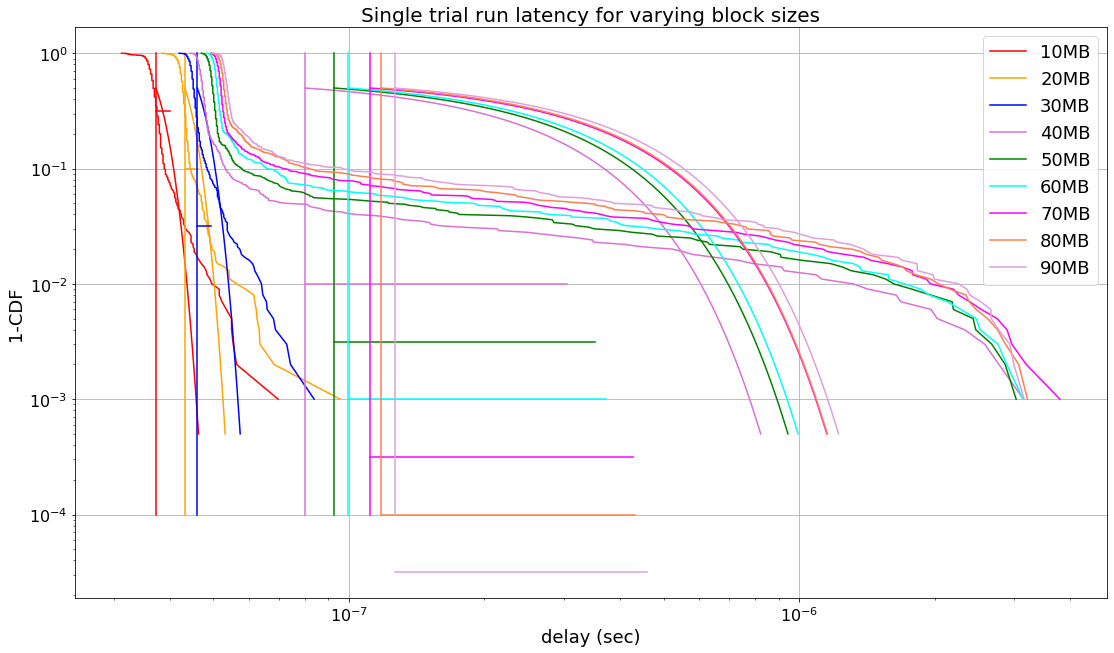

In [28]:
pp = PdfPages('MemoryBlockFigure.pdf')
figure(figsize=(6,4))

Colors=['red', 'orange', 'blue', 'orchid', 'green', 'aqua', 'fuchsia', 'coral', 'plum', 'olive']  # The colors for the plot
LineStyles=['-']

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5,10.5)

for m_i in range(len(m_list)):
    Color=Colors[m_i % len(Colors)]
    PlotTime(TMem[m_i],_mean[m_i],_std[m_i],\
             Color=Color,LS='-',Legend=m_legend[m_i],\
             m_i=m_i)

grid()
legend(fontsize=18)
title('Single trial run latency for varying block sizes', fontsize=20)
xlabel('delay (sec)',fontsize=18)
ylabel('1-CDF',fontsize=18)
tick_params(axis='both', which='major', labelsize=16)
tick_params(axis='both', which='minor', labelsize=12)
pp.savefig()
pp.close()


## Visualize the averaged means, standard deviations over an hour:

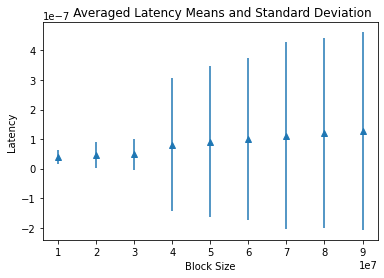

In [29]:
import matplotlib.pyplot as plt
import numpy as np


means = []
stds = []
for i in range(0, int(len(means_stds)/2)): 
    means.append(means_stds[2*i])
    stds.append(means_stds[2*i+1])


x = m_list
y = means
e = stds

plt.errorbar(x, y, e, linestyle='None', marker='^')

# Add title and axis names
plt.title('      Averaged Latency Means and Standard Deviation')
plt.xlabel('Block Size')
plt.ylabel('Latency')

plt.show()


# Statistical Analysis

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import ttest_ind
from matplotlib.figure import Figure

t3asmall = pickle.load( open( 'data/t3asmall.pkl', "rb" ) )
t2small = pickle.load(open('data/t2small.pkl', 'rb'))
t3asmall_df = pd.DataFrame(t3asmall)
t2small_df  = pd.DataFrame(t2small)

| Instance Type | Processor | L1d cache | L2 cache | L3 cache |
| --- | --- | --- |--- | --- |
| t2.small | Intel Xeon E5-2676 | 12 x 32 KB |12 x 256 KB |30 MB|
| t3a.small | AMD EPYC 7571 | 32 x 32 KB |	32 x 512 KB |8 x 8 MB|

The effecticve cahce size of t2.small instance is ~33MB.

The effecticve cahce size of t3a.small instance is ~80MB

In [38]:
m_legend = ['10MB', '20MB', '30MB', '40MB', '50MB', '60MB', '70MB']

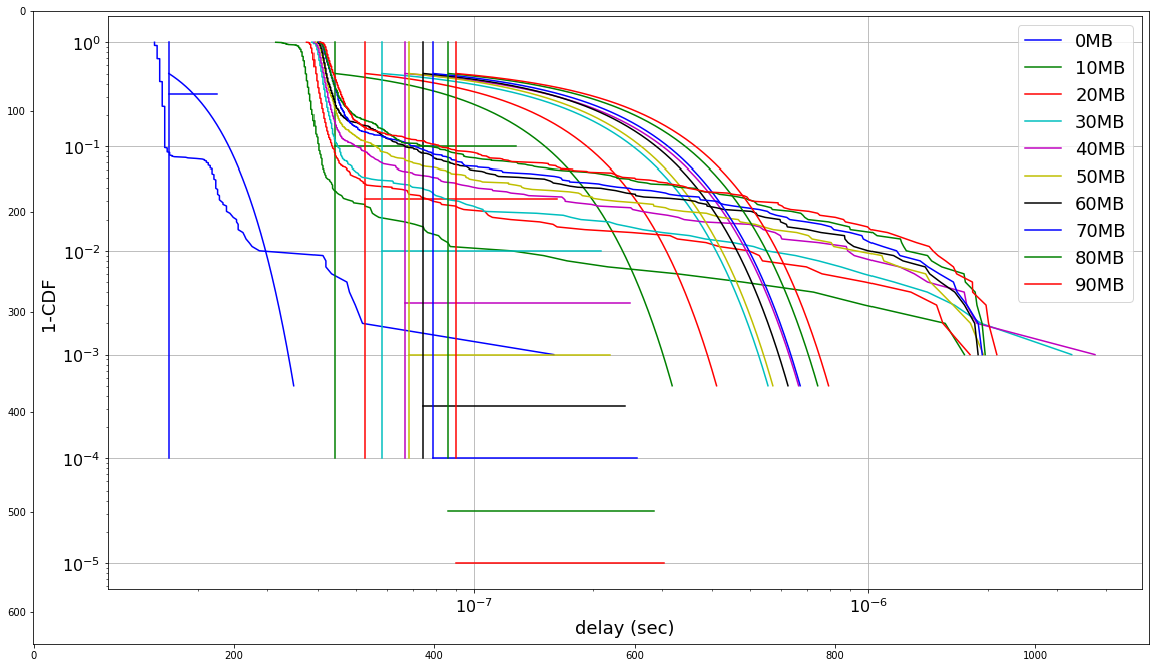

In [2]:
image = mpimg.imread("fig/t3a.png")
plt.figure(figsize=(20,13))
plt.imshow(image)
plt.show()

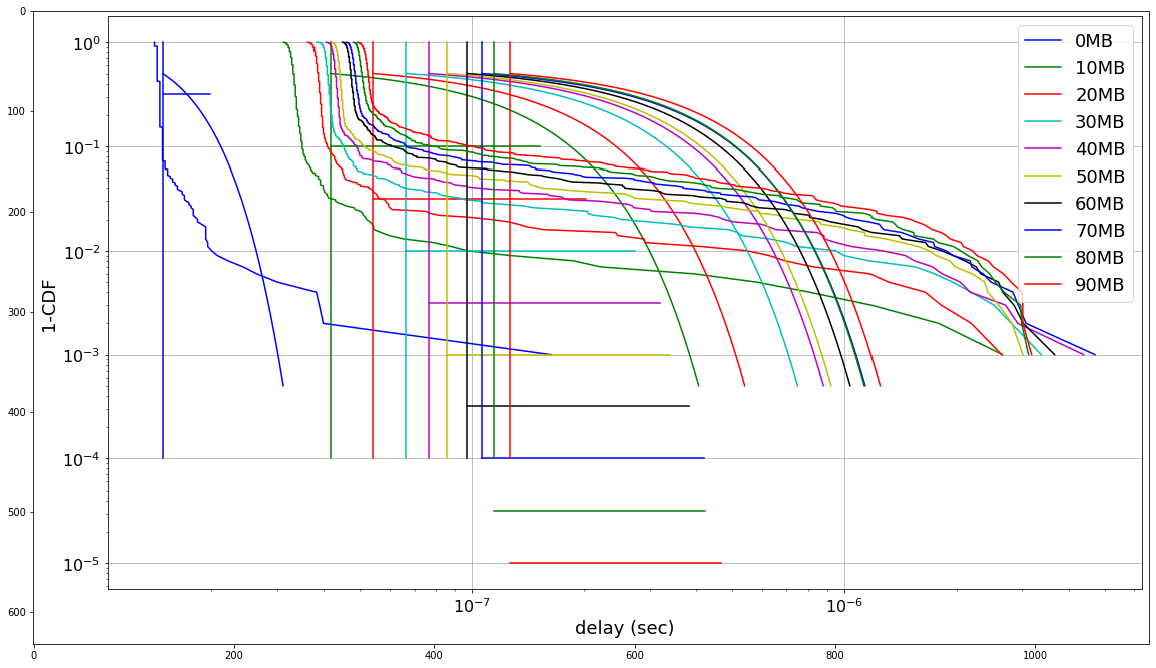

In [3]:
image = mpimg.imread("fig/t2.png")
plt.figure(figsize=(20,13))
plt.imshow(image)
plt.show()

In [6]:
t3asmall_df.head()

,m_i,m,memory__mean,memory__std,memory_latencies
0,0,1,1.685405e-08,5.504783e-09,"[1.5497207641601563e-08, 1.5497207641601563e-0..."
1,1,10000000,4.430246e-08,8.310980e-08,"[3.147125244140625e-08, 3.1709671020507814e-08..."
2,2,20000000,5.288959e-08,1.091091e-07,"[3.7670135498046875e-08, 3.790855407714844e-08..."
3,3,30000000,5.822659e-08,1.513713e-07,"[3.886222839355469e-08, 3.886222839355469e-08,..."
4,4,40000000,6.662321e-08,1.819778e-07,"[3.9339065551757814e-08, 3.9339065551757814e-0..."


In [7]:
t2small_df.head()

,m_i,m,memory__mean,memory__std,memory_latencies
0,0,1,1.480818e-08,4.974807e-09,"[1.4066696166992187e-08, 1.4066696166992187e-0..."
1,1,10000000,4.158306e-08,1.108636e-07,"[3.123283386230469e-08, 3.123283386230469e-08,..."
2,2,20000000,5.409956e-08,1.477794e-07,"[3.62396240234375e-08, 3.647804260253906e-08, ..."
3,3,30000000,6.635499e-08,2.075150e-07,"[3.814697265625e-08, 3.8623809814453126e-08, 3..."
4,4,40000000,7.642007e-08,2.439618e-07,"[4.053115844726563e-08, 4.053115844726563e-08,..."


 - The p-test for the case of 10, 20, 30, 40, 50MB is greater than 0.05 and for the rest of the block sizes we can reject the Null hypothesis in the favor of out Alternative hypothesis.
 - Our hypotheis is correct because when the block size becomes considerably larger the L3 cache size of the t2.small instance but is still smaller than the L3 cache size of t3a.small, than the t3a.small performs better than t2.small.

In [8]:

for idx in range(0, 10):
    t3 = t3asmall_df.loc[idx, 'memory_latencies']
    t2 = t2small_df.loc[idx, 'memory_latencies']
    print('t-test for {}0MB'.format(idx))
    print(ttest_ind(t3, t2))

t-test for 00MB
Ttest_indResult(statistic=8.715188670543206, pvalue=5.979098166289906e-18)
t-test for 10MB
Ttest_indResult(statistic=0.6203383052222069, pvalue=0.5351058276619569)
t-test for 20MB
Ttest_indResult(statistic=-0.20819176098143696, pvalue=0.8351004609545761)
t-test for 30MB
Ttest_indResult(statistic=-1.0002208838885052, pvalue=0.3173247428554567)
t-test for 40MB
Ttest_indResult(statistic=-1.0173865814162821, pvalue=0.30909274067238474)
t-test for 50MB
Ttest_indResult(statistic=-1.8625586578953108, pvalue=0.06267105769189524)
t-test for 60MB
Ttest_indResult(statistic=-2.1669210167912007, pvalue=0.030358703917979624)
t-test for 70MB
Ttest_indResult(statistic=-2.4062578203510343, pvalue=0.01620717247610227)
t-test for 80MB
Ttest_indResult(statistic=-2.422890259943754, pvalue=0.015485945923862609)
t-test for 90MB
Ttest_indResult(statistic=-2.8997619130330112, pvalue=0.0037752431570886626)


In [4]:
t3asmall_df['memory_min'] = t3asmall_df['memory_latencies'].apply(lambda x: min(x))
t3asmall_df['memory_max'] = t3asmall_df['memory_latencies'].apply(lambda x: max(x))
t2small_df['memory_min'] = t2small_df['memory_latencies'].apply(lambda x: min(x))
t2small_df['memory_max'] = t2small_df['memory_latencies'].apply(lambda x: max(x))

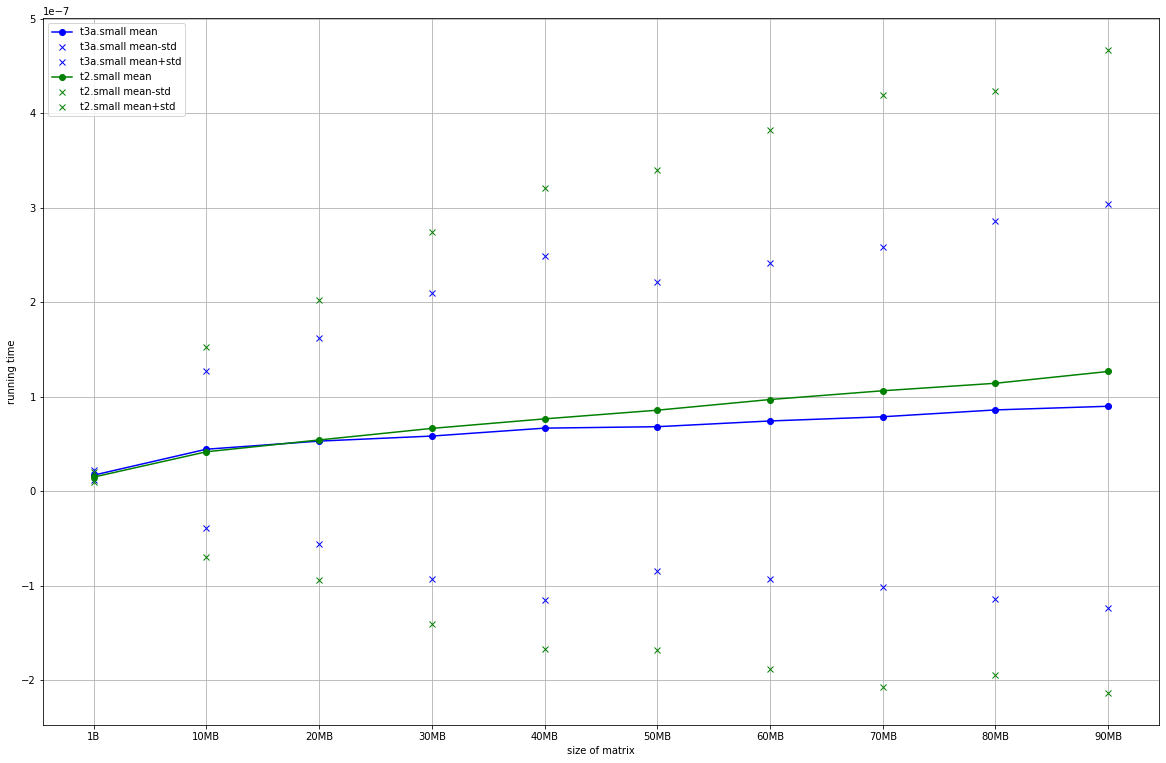

In [7]:
m_legend=['1B','10MB', '20MB', '30MB', '40MB', '50MB', '60MB', '70MB', '80MB', '90MB']
plt.figure(figsize=(20,13))
plt.plot(m_legend, t3asmall_df['memory__mean'],'o-b',label='t3a.small mean')
plt.plot(m_legend,t3asmall_df['memory__mean']-t3asmall_df['memory__std'],'xb',label='t3a.small mean-std')
plt.plot(m_legend,t3asmall_df['memory__mean']+t3asmall_df['memory__std'],'xb',label='t3a.small mean+std')
plt.plot(m_legend, t2small_df['memory__mean'],'o-g',label='t2.small mean')
plt.plot(m_legend,t2small_df['memory__mean']-t2small_df['memory__std'],'xg',label='t2.small mean-std')
plt.plot(m_legend,t2small_df['memory__mean']+t2small_df['memory__std'],'xg',label='t2.small mean+std')
plt.xlabel('size of matrix')
plt.ylabel('running time')
plt.legend()
plt.grid()

# Acknowledgments
Many components producing the results in this notebook were sourced from the course material for DSC 291 at the University of California San Diego under the instruction of Yoav Freund.  Source material may be freely installed using 
> $ git clone https://github.com/yoavfreund/Public-DSC291